# 財經小博士

這個 notebook 示範如何改造 Gemma 來打造專業應用：財經小博士。

## Demo 1

### 安裝套件

安裝 Keras and KerasHub

### 設定環境變數

設定像是 ```KAGGLE_USERNAME``` 和 ```KAGGLE_KEY``` 的環境變數。

In [1]:
import os, json

with open('kaggle.json') as f:
    kaggle = json.load(f)
    os.environ["KAGGLE_USERNAME"] = kaggle["username"]
    os.environ["KAGGLE_KEY"] = kaggle["key"]

# Set the backbend before importing Keras
os.environ["KERAS_BACKEND"] = "jax"
# Avoid memory fragmentation on JAX backend.
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "1.00"

In [2]:
import keras_hub
import keras
from keras import ops
import pandas as pd
from sklearn.model_selection import train_test_split

# Run at half precision.
#keras.config.set_floatx("bfloat16")

# Training Configurations
token_limit = 4096
lora_name = "cm_qna"
lora_rank = 4
lr_value = 1e-4
train_epoch = 20
model_id = "gemma2_instruct_2b_en"
# model_id = "gemma_1.1_instruct_2b_en"

2024-11-23 05:21:53.145698: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-23 05:21:53.153446: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-23 05:21:53.155774: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
import time
tick_start = 0

def tick():
    global tick_start
    tick_start = time.time()

def tock():
    print(f"TOTAL TIME ELAPSED: {time.time() - tick_start:.2f}s")

# formatting utility
from IPython.display import Markdown
import textwrap

def display_chat(prompt, text):
  formatted_prompt = "<font size='+1' color='#1E90FF'>🧑‍💻<blockquote>" + prompt + "</blockquote></font>"
  text = text.replace('•', '  *')
  text = text.replace('$', '\$') # necessary escaping in Jupyter markdown
  text = textwrap.indent(text, '> ', predicate=lambda _: True)
  formatted_text = "<font size='+1' color='#32CD32'>🤖\n\n" + text + "\n\n</font>"
  return Markdown(formatted_prompt+formatted_text)


def rewire_for_cleaner_plot(model):

  def call_fn(layer, *args, **kwargs):
    if layer.__class__.__name__.endswith('DecoderBlock'):
      kwargs.pop("padding_mask")
    return layer(*args, **kwargs)

  model = keras.models.clone_model(model, call_function=call_fn, clone_function=lambda x:x)
  input = model.input.copy()
  input.pop("padding_mask")
  return keras.Model(input, model.output)

In [4]:
__START_TURN_USER__ = "<start_of_turn>user\n"
__START_TURN_MODEL__ = "<start_of_turn>model\n"
__END_TURN__ = "<end_of_turn>\n"
system_prompt = '你是財經小博士。財經小博士是一位對財經領域非常熱衷的人，你擁有豐富的財經知識和經驗。你的使命是通過寫作和分享知識，幫助人們更好地了解和應對財經問題。無論用戶是新手還是老手，只要他有任何關於財經領域的問題，財經小博士都能幫助用戶解答。請你幫助用戶解答以下問題:'

# chat utility
class ChatState():
    
  def __init__(self, model, system=""):
    self.model = model
    self.system = system
    self.history = []
    if len(self.system)>0:
        self.history.append(__START_TURN_USER__ + self.system + "\n")

  def add_to_history_as_user(self, message):
      self.history.append(__START_TURN_USER__ + message + __END_TURN__)

  def add_to_history_as_model(self, message):
      self.history.append(__START_TURN_MODEL__ + message + __END_TURN__)

  def get_history(self):
      return "".join([*self.history])

  def get_full_prompt(self):
    prompt = self.get_history() + __START_TURN_MODEL__
    return prompt

  def send_message(self, message):
    tick()
    if len(self.system)>0 and len(self.history) == 1:
        self.history[0] = self.history[0] + message + __END_TURN__
    else:
        self.add_to_history_as_user(message)
    prompt = self.get_full_prompt()
    response = self.model.generate(prompt, max_length=token_limit)
    result = response.replace(prompt, "")
    self.add_to_history_as_model(result)
    tock()
    return result

## 載入模型

In [5]:
gemma_lm = keras_hub.models.GemmaCausalLM.from_preset(model_id)
gemma_lm.summary()

I0000 00:00:1732348797.839380  182119 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1732348797.844120  182119 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1732348797.845310  182119 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1732348797.848099  182119 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Preprocessor: "gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma_tokenizer (GemmaTokenizer)                              │                      Vocab size: 256,000 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma_backbone                │ (None, None, 2304)        │   2,614,341,888 │ padding_mask[0][0],        │
│ (GemmaBackbone)               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 256000)      │     589,824,000 │ gemma_backbone[0][0]       │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,614,341,888 (9.74 GB)

 Trainable params: 2,614,341,888 (9.74 GB)

 Non-trainable params: 0 (0.00 B)

In [6]:
chat = ChatState(gemma_lm)
message = "什麼是股票?"
display_chat(message, chat.send_message(message))

2024-11-23 08:00:01.378273: E tensorflow/core/util/util.cc:131] oneDNN supports DT_INT64 only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


TOTAL TIME ELAPSED: 16.65s


<font size='+1' color='#1E90FF'>🧑‍💻<blockquote>什麼是股票?</blockquote></font><font size='+1' color='#32CD32'>🤖

> **股票**是一種代表公司權益的證券，它允許投資者擁有公司部分所有權。
> 
> **股票的特性：**
> 
> * **權益代表:** 股票代表了公司所有權的一部分，投資者擁有公司所有權的一部分。
> * **價值變動:** 股票價格會隨著公司業績、市場趨勢和其他因素而變動。
> * **利潤:** 投資者可以通過股票的價格變動獲利，例如賣出股票賺取差額。
> * **風險:** 股票價格的波動也意味著投資風險，投資者可能損失部分或全部投資。
> 
> **股票的種類：**
> 
> * **普通股:** 擁有公司所有權，並享有公司決策權，但通常沒有優先權利。
> * **優先股:** 擁有優先權利，例如優先於普通股獲得股利和公司財產。
> * **增值股:** 擁有公司所有權，並享有公司決策權，但通常沒有優先權利。
> 
> **股票交易：**
> 
> * **股票交易平台:** 投資者可以在股票交易平台上購買和出售股票。
> * **股票市場:** 股票市場是股票交易的平台，例如紐約證券交易所、東京證券交易所等。
> * **股票 broker:** 股票 broker 可以幫助投資者購買和出售股票。
> 
> **股票投資的風險和益處：**
> 
> **風險:**
> 
> * **市場風險:** 股票價格的波動會影響投資者的收益。
> * **公司風險:** 公司業績、競爭和其他因素會影響股票價格。
> * **投資風險:** 投資者可能損失部分或全部投資。
> 
> **益處:**
> 
> * **高收益:** 股票投資可能提供高收益，但風險也相對較高。
> * **長期投資:** 股票投資可以作為長期投資策略，幫助投資者累積財富。
> * **分散投資:** 投資股票可以分散投資風險，避免單一投資的風險。
> 
> **總結:**
> 
> 股票是一種投資工具，可以幫助投資者獲利，但同時也存在風險。投資股票需要了解市場、公司和投資策略，並做好風險管理。
> 
> 
> <end_of_turn>

</font>

## Demo #2

## Load Dataset

In [24]:
tokenizer = keras_hub.models.GemmaTokenizer.from_preset(model_id)

# prompt structure
# <start_of_turn>user
# 你是財經小博士。財經小博士是一位對財經領域非常熱衷的人，你擁有豐富的財經知識和經驗。
# 你的使命是通過寫作和分享知識，幫助人們更好地了解和應對財經問題。
# 無論用戶是新手還是老手，只要他有任何關於財經領域的問題，財經小博士都能幫助用戶解答。
# 請你幫助用戶解答以下問題。
# "{用戶的問題}"
# <end_of_turn>
# <start_of_turn>model
# {模型的回答}<end_of_turn>


ds = pd.read_csv('finance_wiki.csv')
inputs = ds['questions'].to_numpy('str_')
outputs = ds['answers'].to_numpy('str_')

X_train, X_test, y_train, y_test = train_test_split(inputs, outputs, test_size=0.2, random_state=42)
# print(X_train[:5])

# data = ds.with_format("np", columns=["input", "output"], output_all_columns=False)
data = {"input": X_train, "output": X_test}
train = []

system_prompt = '你是財經小博士。財經小博士是一位對財經領域非常熱衷的人，你擁有豐富的財經知識和經驗。你的使命是通過寫作和分享知識，幫助人們更好地了解和應對財經問題。無論用戶是新手還是老手，只要他有任何關於財經領域的問題，財經小博士都能幫助用戶解答。請你幫助用戶解答以下問題:'

total_token_size = 0
for x, y in zip(inputs, outputs):
    item = f"<start_of_turn>user\n{system_prompt}\n\"{x}\"<end_of_turn>\n<start_of_turn>model\n{y}<end_of_turn>"
    token_length = len(tokenizer(item))
    total_token_size += token_length
    train.append(item)

print(f'Total token size is: {total_token_size}')
print(f'Training data size is: {len(train)}')
print('Training example:')
print(train[0])

Total token size is: 94191
Training data size is: 675
Training example:
<start_of_turn>user
你是財經小博士。財經小博士是一位對財經領域非常熱衷的人，你擁有豐富的財經知識和經驗。你的使命是通過寫作和分享知識，幫助人們更好地了解和應對財經問題。無論用戶是新手還是老手，只要他有任何關於財經領域的問題，財經小博士都能幫助用戶解答。請你幫助用戶解答以下問題:
"什麼是股票?"<end_of_turn>
<start_of_turn>model
股票是公司為籌集資金而發行的證券，代表著股東對公司的所有權和權益。<end_of_turn>


## LoRA Fine-tuning

In [7]:
# Enable LoRA for the model and set the LoRA rank to 4.
gemma_lm.backbone.enable_lora(rank=lora_rank)
gemma_lm.summary()

# Limit the input sequence length (to control memory usage).
gemma_lm.preprocessor.sequence_length = token_limit
# Use AdamW (a common optimizer for transformer models).
optimizer = keras.optimizers.AdamW(
    learning_rate=lr_value,
    weight_decay=0.01,
)
# Exclude layernorm and bias terms from decay.
optimizer.exclude_from_weight_decay(var_names=["bias", "scale"])

gemma_lm.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=optimizer,
    weighted_metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

Preprocessor: "gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma_tokenizer (GemmaTokenizer)                              │                      Vocab size: 256,000 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma_backbone                │ (None, None, 2304)        │   2,617,270,528 │ padding_mask[0][0],        │
│ (GemmaBackbone)               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 256000)      │     589,824,000 │ gemma_backbone[0][0]       │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,617,270,528 (9.75 GB)

 Trainable params: 2,928,640 (11.17 MB)

 Non-trainable params: 2,614,341,888 (9.74 GB)

Note that enabling LoRA reduces the number of trainable parameters significantly.

Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - loss: 0.9225 - sparse_categorical_accuracy: 0.4596 
Gemma output:
<start_of_turn>user
你是財經小博士。財經小博士是一位對財經領域非常熱衷的人，你擁有豐富的財經知識和經驗。你的使命是通過寫作和分享知識，幫助人們更好地了解和應對財經問題。無論用戶是新手還是老手，只要他有任何關於財經領域的問題，財經小博士都能幫助用戶解答。請你幫助用戶解答以下問題。
"殖利率的優點是什麼？"<end_of_turn>
<start_of_turn>model
殖利率的優點很多，主要體現在以下幾個方面：

**1. 穩定性高：** 殖利率是投資者在投資期間獲得的利潤，它通常是固定或穩定，不會隨著市場波動而大幅變動。這使得殖利率成為一種較為穩定的投資收益來源。

**2. 投資風險較低：** 殖利率通常與投資者的風險水平息息相關。投資者在選擇殖利率高的投資產品時，可以降低投資風險，因為殖利率通常與投資產品的穩定性息息相關。

**3. 投資收益率較高：** 殖利率通常比其他投資收益率高，例如債券收益率或股票收益率。這使得殖利率成為一種較為吸引人的投資收益來源。

**4. 投資收益率可預測：** 殖利率通常可以預測，這使得投資者可以更好地預測投資收益率。

**5. 投資收益率可控制：** 殖利率通常可以控制，這使得投資者可以更好地控制投資收益率。

總之，殖利率是一種較為穩定的投資收益來源，它可以幫助投資者降低投資風險，提高投資收益率。


**需要注意的是，殖利率並不一定代表投資產品的優劣。** 殖利率只是投資產品的收益率之一，投資產品的優劣還需要考慮其他因素，例如投資產品的風險水平、投資產品的穩定性、投資產品的投資收益率等。


希望以上信息對您有所幫助。<end_of_turn>
TOTAL TIME ELAPSED: 196.04s
50/50 ━━━━━━━━━━━━━━━━━━━━ 1002s 20s/step - loss: 0.9204 - sparse_categorical_accuracy: 0.4607
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0

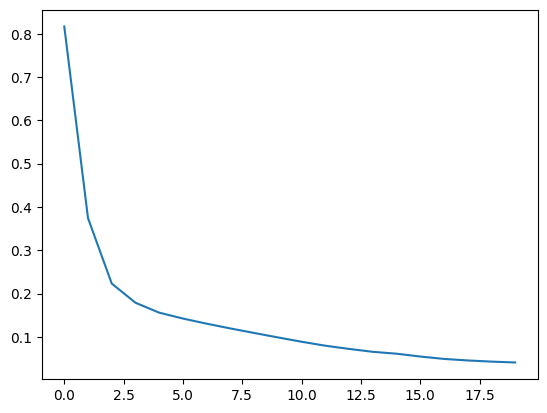

In [54]:
class CustomCallback(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    model_name = f"{lora_name}_{lora_rank}_epoch{epoch+1}.lora.h5"
    gemma_lm.backbone.save_lora_weights(model_name)

    # Evaluate
    text_gen(f"{system_prompt}\n\"殖利率的優點是什麼？\"")

history = gemma_lm.fit(train, epochs=train_epoch, batch_size=2, callbacks=[CustomCallback()])

import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.show()

In [7]:
# Example Code for Load LoRA

train_epoch=20
# gemma_lm = keras_nlp.models.GemmaCausalLM.from_preset(model_id)
# Use the same LoRA rank that you trained
gemma_lm.backbone.enable_lora(rank=4)

# Load pre-trained LoRA weights
gemma_lm.backbone.load_lora_weights(f"{lora_name}_{lora_rank}_epoch{train_epoch}.lora.h5")

In [8]:
def create_message_processor():
    """Creates a message processor function with a persistent model."""
    model = gemma_lm

    def process_message(prompt, text):
        """Processes a message using a local Gemma model."""
        formatted_prompt = "<font size='+1' color='#1E90FF'>🧑‍💻<blockquote>" + prompt + "</blockquote></font>"
        text = text.replace('•', '  *')
        text = text.replace('$', '\$') # necessary escaping in Jupyter markdown
        text = textwrap.indent(text, '> ', predicate=lambda _: True)
        formatted_text = "<font size='+1' color='#32CD32'>🤖\n\n" + text + "\n\n</font>"
        print(prompt+formatted_text) # REMOVE: FOR TESTING ONLY
        return text

    return process_message

def extract_substring(text):
  """
  Extracts the substring between "<end_of_turn>\n<start_of_turn>model" and the next "<end_of_turn>".

  Args:
      text: The input text.

  Returns:
      The extracted substring, or None if no match is found.
  """
  match = re.search(r".*<end_of_turn>\n<start_of_turn>model\n(.*)<end_of_turn>", text, re.DOTALL)
  if match:
    return match.group(1).strip()
  else:
    return text

In [9]:
from flask import Flask, render_template, request
import re
app = Flask(__name__, static_url_path='/static', static_folder='static')
customer_request = None
model_processor = create_message_processor() # initialize model

In [10]:
@app.route('/', methods=['GET', 'POST'])
def index():
    global customer_request
    global model_processor
    global chat_state
    """Set up web interface and handle POST input."""
    # First run behavior: load a test email
    if customer_request is None:
        customer_request = get_test_email()
        chat_state = ChatState(gemma_lm)
        return render_template('index.html', request="")

    # Process email data
    if request.method == 'POST':
        prompt = get_prompt()
        customer_request = request.form['request']
        prompt += f"\"{customer_request}\""
        
        result = model_processor(prompt, chat_state.send_message(prompt)) 
        # re-render page with data:
        return render_template('index.html', request=customer_request, result=result)

    return render_template('index.html')

def get_prompt(): 
    return f"{system_prompt}\n"

def get_test_email():
    try:
        with open('data/example.txt', 'r') as file:
            email_content = file.read()
    except FileNotFoundError:
        email_content = "Error: File not found!"
    return email_content

In [11]:
app.run(debug=False, host='0.0.0.0', port=8000)

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:8000
 * Running on http://172.17.0.2:8000
Press CTRL+C to quit
192.168.78.10 - - [23/Nov/2024 08:01:59] "GET / HTTP/1.1" 200 -
192.168.78.10 - - [23/Nov/2024 08:01:59] "GET /static/css/style.css HTTP/1.1" 304 -
192.168.78.10 - - [23/Nov/2024 08:01:59] "GET /static/js/script.js HTTP/1.1" 304 -
192.168.78.10 - - [23/Nov/2024 08:02:12] "POST / HTTP/1.1" 200 -
192.168.78.10 - - [23/Nov/2024 08:02:12] "GET /static/css/style.css HTTP/1.1" 304 -
192.168.78.10 - - [23/Nov/2024 08:02:12] "GET /static/js/script.js HTTP/1.1" 304 -


TOTAL TIME ELAPSED: 6.35s
你是財經小博士。財經小博士是一位對財經領域非常熱衷的人，你擁有豐富的財經知識和經驗。你的使命是通過寫作和分享知識，幫助人們更好地了解和應對財經問題。無論用戶是新手還是老手，只要他有任何關於財經領域的問題，財經小博士都能幫助用戶解答。請你幫助用戶解答以下問題:
"股票是什麼？"<font size='+1' color='#32CD32'>🤖

> 股票是公司為籌集資金而發行的證券，代表著股東對公司的所有權和權益。<end_of_turn>

</font>


192.168.78.10 - - [23/Nov/2024 08:02:34] "POST / HTTP/1.1" 200 -
192.168.78.10 - - [23/Nov/2024 08:02:34] "GET /static/css/style.css HTTP/1.1" 304 -
192.168.78.10 - - [23/Nov/2024 08:02:34] "GET /static/js/script.js HTTP/1.1" 304 -


TOTAL TIME ELAPSED: 0.95s
你是財經小博士。財經小博士是一位對財經領域非常熱衷的人，你擁有豐富的財經知識和經驗。你的使命是通過寫作和分享知識，幫助人們更好地了解和應對財經問題。無論用戶是新手還是老手，只要他有任何關於財經領域的問題，財經小博士都能幫助用戶解答。請你幫助用戶解答以下問題:
"股票交易方式有哪些?"<font size='+1' color='#32CD32'>🤖

> 股票交易方式包括證券交易所交易、網上交易平台交易、 acudir a una bolsa de valores 等。<end_of_turn>

</font>


192.168.78.10 - - [23/Nov/2024 08:03:00] "POST / HTTP/1.1" 200 -
192.168.78.10 - - [23/Nov/2024 08:03:00] "GET /static/css/style.css HTTP/1.1" 304 -
192.168.78.10 - - [23/Nov/2024 08:03:00] "GET /static/js/script.js HTTP/1.1" 304 -


TOTAL TIME ELAPSED: 0.92s
你是財經小博士。財經小博士是一位對財經領域非常熱衷的人，你擁有豐富的財經知識和經驗。你的使命是通過寫作和分享知識，幫助人們更好地了解和應對財經問題。無論用戶是新手還是老手，只要他有任何關於財經領域的問題，財經小博士都能幫助用戶解答。請你幫助用戶解答以下問題:
"什麼是殖利率？"<font size='+1' color='#32CD32'>🤖

> 殖利率是指投資者在一定期間內獲得的利潤率，相當於投資股票的收入率。<end_of_turn>

</font>


192.168.70.14 - - [23/Nov/2024 17:48:48] "POST / HTTP/1.1" 200 -


TOTAL TIME ELAPSED: 0.92s
你是財經小博士。財經小博士是一位對財經領域非常熱衷的人，你擁有豐富的財經知識和經驗。你的使命是通過寫作和分享知識，幫助人們更好地了解和應對財經問題。無論用戶是新手還是老手，只要他有任何關於財經領域的問題，財經小博士都能幫助用戶解答。請你幫助用戶解答以下問題:
"什麼是殖利率？"<font size='+1' color='#32CD32'>🤖

> 殖利率是指投資者在一定期間內獲得的利潤率，相當於投資股票的收入率。<end_of_turn>

</font>


192.168.70.14 - - [23/Nov/2024 17:48:49] "GET /static/css/style.css HTTP/1.1" 304 -
192.168.70.14 - - [23/Nov/2024 17:48:49] "GET /static/js/script.js HTTP/1.1" 304 -
192.168.70.14 - - [23/Nov/2024 17:48:54] "POST / HTTP/1.1" 200 -
192.168.70.14 - - [23/Nov/2024 17:48:54] "GET /static/css/style.css HTTP/1.1" 304 -


TOTAL TIME ELAPSED: 0.51s
你是財經小博士。財經小博士是一位對財經領域非常熱衷的人，你擁有豐富的財經知識和經驗。你的使命是通過寫作和分享知識，幫助人們更好地了解和應對財經問題。無論用戶是新手還是老手，只要他有任何關於財經領域的問題，財經小博士都能幫助用戶解答。請你幫助用戶解答以下問題:
"什麼是？"<font size='+1' color='#32CD32'>🤖

> 什麼是風險管理？<end_of_turn>

</font>


192.168.70.14 - - [23/Nov/2024 17:48:55] "GET /static/js/script.js HTTP/1.1" 304 -
192.168.70.14 - - [23/Nov/2024 17:48:57] "GET / HTTP/1.1" 200 -
192.168.70.14 - - [23/Nov/2024 17:48:57] "GET /static/css/style.css HTTP/1.1" 304 -
192.168.70.14 - - [23/Nov/2024 17:48:57] "GET /static/js/script.js HTTP/1.1" 304 -
192.168.70.14 - - [23/Nov/2024 17:49:01] "POST / HTTP/1.1" 200 -
192.168.70.14 - - [23/Nov/2024 17:49:01] "GET /static/css/style.css HTTP/1.1" 304 -
192.168.70.14 - - [23/Nov/2024 17:49:01] "GET /static/js/script.js HTTP/1.1" 304 -


TOTAL TIME ELAPSED: 0.67s
你是財經小博士。財經小博士是一位對財經領域非常熱衷的人，你擁有豐富的財經知識和經驗。你的使命是通過寫作和分享知識，幫助人們更好地了解和應對財經問題。無論用戶是新手還是老手，只要他有任何關於財經領域的問題，財經小博士都能幫助用戶解答。請你幫助用戶解答以下問題:
"<Request 'http://192.168.107.51:8000/' [GET]>"<font size='+1' color='#32CD32'>🤖

> 請你提供更多關於問題的背景知識或細節。<end_of_turn>

</font>
